# Andrew Ng's Machine Learning Exercise 4: Neural Networks Learning

In [1]:
from __future__ import division

In [2]:
import numpy as np
from scipy.optimize import minimize
import scipy.io # used to load matlab-formatted .m files.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [3]:
%matplotlib inline  

In [4]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

In [5]:
def sns_reset(): 
    """Call this function to toggle back to the sns plotting environment from the matplotlib environment."""
    sns.reset_defaults()
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("notebook")

# Call these three functions at the top of the notebook to allow toggling between sns and matplotlib 
# environments while maintaining a uniform plot style throughout.
sns.reset_orig() 
sns_reset()
plt.ion()

Load the dataset used in both sections below.

In [6]:
data_dict = scipy.io.loadmat('ex4_orig_octave/ex4data1.mat')

In [7]:
X = data_dict['X']
y = data_dict['y'].ravel()

M = X.shape[0] # = 400 pixels per sample
N = X.shape[1] # = 5000 samples
L = 26 # = number of nodes in the hidden layer (including bias node)
K = len(np.unique(y)) # = 10 distinct classes for this example.

Add a column of ones to the data matrix that allows us to treat the intercept parameter as a feature.

In [8]:
X = np.hstack((np.ones((M, 1)), X)) 

Define the sigmoid function.

In [9]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

Generate a one-hot encoding, Y,  of the target vector, y.

In [10]:
Y = np.zeros((M, K), dtype='uint8') 

for i, row in enumerate(Y):
    Y[i, y[i] - 1] = 1

Load the saved neural network parameters (the trained neural network weights).

In [11]:
weights_dict = scipy.io.loadmat('ex4_orig_octave/ex4weights.mat')

In [12]:
theta_1 = weights_dict['Theta1'] # theta_1.shape = (25, 401)
theta_2 = weights_dict['Theta2'] # theta_2.shape = (10, 26)

nn_params_saved = np.concatenate((theta_1.flatten(), theta_2.flatten()))

# 1 Neural networks

## 1.1 Visualizing the data

Same visualization using the same dataset as in Exercise 3, section 1.1:  Draw ```dim * dim``` random examples of images from the dataset and display them in a grid.  Note:  Drop column of ones from X here.

In [13]:
dim = K

examples = X[:, 1:][np.random.randint(M, size=dim * dim)]

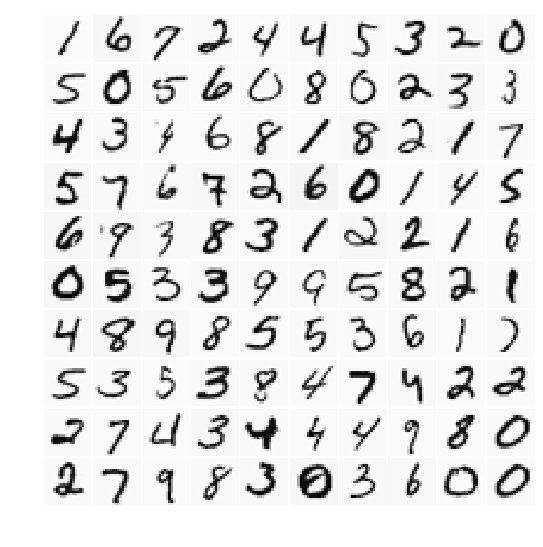

In [14]:
"""Python version of displayData.m."""
fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in xrange(dim):
    for j in xrange(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(examples[k].reshape(int(np.sqrt(N)), int(np.sqrt(N))).T,
            cmap=plt.get_cmap('Greys'), interpolation='nearest')
        k += 1
        
plt.savefig('ex4_plots/fig_1.png', dpi=300)

## 1.3 Feedforward and cost function

Given the saved neural network parameters, feedforward to calculate the cost function.

In [15]:
def nn_cost_function(nn_params, X, Y, M, N, L, K):
    """Python version of nnCostFunction.m after completing 'Part 1'."""

    # Unroll the parameter vector.
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    # Calculate activations in the second layer.
    a_2 = sigmoid(theta_1.dot(X.T))
    
    # Add the second layer's bias node.
    a_2_p = np.vstack((np.ones(M), a_2))
    
    # Calculate the activation of the third layer.
    a_3 = sigmoid(theta_2.dot(a_2_p))
    
    # Calculate the cost function.
    cost = 1 / M * np.trace(- Y.dot(np.log(a_3)) - (1 - Y).dot(np.log(1 - a_3)))
    
    return cost

In [16]:
cost_saved = nn_cost_function(nn_params_saved, X, Y, M, N, L, K) 

print 'Cost at parameters (loaded from ex4weights): %.6f' % cost_saved
print '(this value should be about 0.287629)'

Cost at parameters (loaded from ex4weights): 0.287629
(this value should be about 0.287629)


## 1.4 Regularized cost function

Add a regularization term to the cost function.  Note: Bias parameters are not regularized.

In [17]:
def nn_cost_function_reg(nn_params, X, Y, M, N, L, K, lam):
    """Python version of nnCostFunction.m after completing 'Part 1' with regularization added."""

    # Unroll the parameter vector.
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    # Calculate activations in the second layer.
    a_2 = sigmoid(theta_1.dot(X.T))
    
    # Add the second layer's bias node.
    a_2_p = np.vstack((np.ones(M), a_2))
    
    # Calculate the activation of the third layer.
    a_3 = sigmoid(theta_2.dot(a_2_p))
    
    # Calculate the cost function with the addition of a regularization term.
    cost = 1 / M * np.trace(- Y.dot(np.log(a_3)) - (1 - Y).dot(np.log(1 - a_3))) \
        + lam / 2 / M * (np.sum(theta_1[:, 1:] * theta_1[:, 1:]) + np.sum(theta_2[:, 1:] * theta_2[:, 1:]))
            
    return cost

In [18]:
cost_saved_reg = nn_cost_function_reg(nn_params_saved, X, Y, M, N, L, K, 1)

print 'Regularized cost at parameters (loaded from ex4weights): %.6f' % cost_saved_reg
print '(this value should be about 0.383770)'

Regularized cost at parameters (loaded from ex4weights): 0.383770
(this value should be about 0.383770)


# 2 Backpropagation

## 2.1 Sigmoid gradient

In [19]:
"""Python version of sigmoidGradient.m."""
sigmoid_gradient = lambda x: sigmoid(x) * (1 - sigmoid(x))

In [20]:
print 'Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:', \
    ', '.join('%.3f' % item for item in sigmoid_gradient(np.array([-1, -0.5, 0, 0.5, 1])))
print '(should be an even function)'

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: 0.197, 0.235, 0.250, 0.235, 0.197
(should be an even function)


## 2.2 Random initialization

Draw initial values of the neural network parameters from a uniform distribution on the open interval $(-\epsilon_{\rm init}, \epsilon_{\rm init})$.

In [21]:
eps_init = 0.12

In [22]:
"""Python version of randInitializeWeights.m."""
theta_1_0 = np.random.uniform(-eps_init, eps_init, theta_1.shape)
theta_2_0 = np.random.uniform(-eps_init, eps_init, theta_2.shape)

nn_params_0 = np.concatenate((theta_1_0.flatten(), theta_2_0.flatten()))

## 2.3 Backpropagation

Expand on the definition of the cost function defined above such that both cost and gradient are returned.

In [23]:
def nn_cost_function_grad(nn_params, X, Y, M, N, L, K, lam):
    """Python version of nnCostFunction.m after completing 'Part 2' 
    (the cost function is regularized here but not the gradient)."""    
    
    # Unroll the parameter vector.
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    """Feedforward pass."""
    # Calculate activations in the second layer (as well as z_2, which is needed below).
    z_2 = theta_1.dot(X.T)
    a_2_p = np.vstack((np.ones(M), sigmoid(z_2)))
    
    # Calculate the activation of the third layer.
    a_3 = sigmoid(theta_2.dot(a_2_p))
    
    # Calculate the cost function with the addition of a regularization term.
    cost = 1 / M * np.trace(- Y.dot(np.log(a_3)) - (1 - Y).dot(np.log(1 - a_3))) \
        + lam / 2 / M * (np.sum(theta_1[:, 1:] * theta_1[:, 1:]) + np.sum(theta_2[:, 1:] * theta_2[:, 1:]))    
    
    """Backpropagation (use the chain rule)."""
    # Calculate the gradient for parameters in the third layer.
    grad_theta_2 = 1 / M * (a_3 - Y.T).dot(a_2_p.T) 
    
    # Calculate the gradient for parameters in the second layer.
    theta_delta = theta_2_0[:, 1:].T.dot(a_3 - Y.T)
    s_g_z_2 = sigmoid_gradient(z_2)
    grad_theta_1 = 1 / M * np.array([[np.sum(theta_delta[p] * s_g_z_2[p] * X.T[q]) 
        for q in xrange(N+1)] for p in xrange(L-1)]) 
    
    # Roll the two gradient vectors into a single vector and return.
    return cost, np.concatenate((grad_theta_1.flatten(), grad_theta_2.flatten()))  

## 2.4 Gradient checking

Compare the gradient as computed from the analytical expression above to the gradient computed numerically based on estimates of the cost function (without regularization) at two nearby points in the neural network parameter space.

In [24]:
def compute_numerical_gradient(indicies_to_check, eps, nn_params, X, Y, M, N, L, K):
    """Python version of computeNumericalGradient.m."""
    numerical_grad = np.zeros(len(indicies_to_check))
    unit_vector = np.zeros(nn_params.shape)
    k = 0
    for i in indicies_to_check:
        unit_vector[i] = eps
        loss_1 = nn_cost_function(nn_params + unit_vector, X, Y, M, N, L, K)
        loss_2 = nn_cost_function(nn_params - unit_vector, X, Y, M, N, L, K)
        numerical_grad[k] =  (loss_1 - loss_2) / (2 * eps)
        unit_vector[i] = 0
        k += 1
    return numerical_grad

Because checking the gradient vector would be somewhat computationally intensive, we perform the comparison of analytical and numerical gradient calculations only on a random subset of gradient vector elements.  

In [25]:
num_to_check = 20

indicies_to_check = np.arange(len(nn_params_0))
np.random.shuffle(indicies_to_check)
indicies_to_check = indicies_to_check[:num_to_check] 

The following few lines calculate the difference between the analytical and numerical computation of random gradient vector elements.

In [26]:
"""Together with the next few lines, this is a Python check similar to the check in checkNNGradients.m."""
_, analytical_grad_random_subset = nn_cost_function_grad(nn_params_0, X, Y, M, N, L, K, 0)
analytical_grad_random_subset = analytical_grad_random_subset[indicies_to_check]
# takes ~20sec to run on my laptop.

In [27]:
eps = 1e-5
numerical_grad_random_subset = compute_numerical_gradient(indicies_to_check, eps, nn_params_0, X, Y, M, N, L, K)

In [28]:
diff = 2 * (analytical_grad_random_subset - numerical_grad_random_subset) / \
    (analytical_grad_random_subset + numerical_grad_random_subset)

This line demonstrates that the largest difference is $O(
10\times\epsilon)$.

In [34]:
np.sum(abs(diff) < 1e-4) == len(diff)

True

## 2.5 Regularized neural networks

Add gradient regularization.  Note: Bias parameters are not regularized.

In [64]:
cost_history = [] # Use this array to log costs calculated in the call to scipy's "minimize" below.

def nn_cost_function_grad_reg(nn_params, X, Y, M, N, L, K, lam):
    """Python version of nnCostFunction.m after completing 'Part 3'."""  
    
    # Unroll the parameter vector.
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    """Feedforward pass."""
    # Calculate activations in the second layer (as well as z_2, which is needed below).
    z_2 = theta_1.dot(X.T)
    a_2_p = np.vstack((np.ones(M), sigmoid(z_2)))
    
    # Calculate the activation of the third layer.
    a_3 = sigmoid(theta_2.dot(a_2_p))
    
    # Calculate the cost function with the addition of a regularization term.
    cost = 1 / M * np.trace(- Y.dot(np.log(a_3)) - (1 - Y).dot(np.log(1 - a_3))) \
        + lam / 2 / M * (np.sum(theta_1[:, 1:] * theta_1[:, 1:]) + np.sum(theta_2[:, 1:] * theta_2[:, 1:]))    
    
    """Backpropagation (use the chain rule)."""
    # Calculate the gradient for parameters in the third layer.
    grad_theta_2 = 1 / M * (a_3 - Y.T).dot(a_2_p.T) \
        + lam / M * np.hstack((np.zeros(K).reshape(-1,1), theta_2[:, 1:])) # this is the theta_2 grad reg term
    
    # Calculate the gradient for parameters in the second layer.
    theta_delta = theta_2_0[:, 1:].T.dot(a_3 - Y.T)
    s_g_z_2 = sigmoid_gradient(z_2)
    grad_theta_1 = 1 / M * np.array([[np.sum(theta_delta[p] * s_g_z_2[p] * X.T[q]) 
        for q in xrange(N+1)] for p in xrange(L-1)]) \
        + lam / M * np.hstack((np.zeros(L-1).reshape(-1,1), theta_1[:, 1:])) # this is the theta_1 grad reg term
    
    # Roll the two gradient vectors into a single vector.
    grad = np.concatenate((grad_theta_1.flatten(), grad_theta_2.flatten()))  
    
    cost_history.append(cost)
    return cost, grad

## 2.6 Learning parameters

For a regularization parameter set to 1 and random initial neural network parameter values as drawn above, train the network.

In [108]:
lam = 1

In [109]:
cost_history = []

res = minimize(nn_cost_function_grad_reg, nn_params_0, 
               method='L-BFGS-B', args=(X, Y, M, N, L, K, lam), jac=True, options={'maxiter': 100}) 

In [112]:
nn_params_learned = res['x']
np.savetxt('ex4_weights_learned/nn_params_learned.txt', nn_params_learned)

print 'Cost at best-fit theta: %.3f' % res['fun'] 

Cost at best-fit theta: 0.670


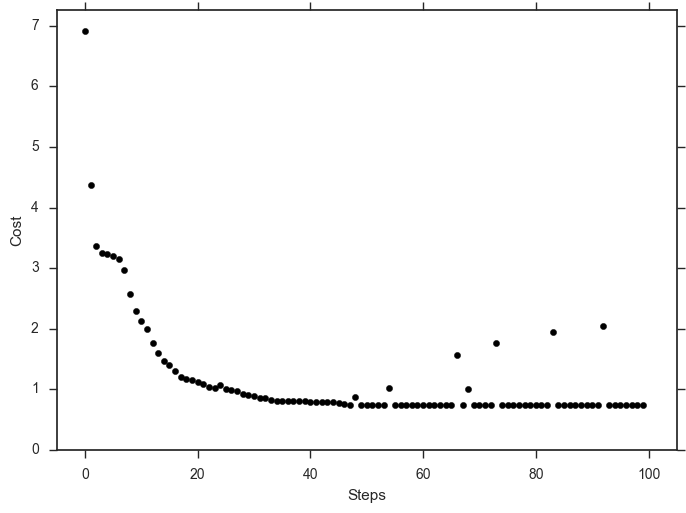

In [111]:
num_steps = 100

plt.figure()
plt.scatter(np.arange(num_steps), np.array(cost_history[:num_steps]), c='k', marker='o')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.xlim(-num_steps * 0.05, num_steps * 1.05)
plt.ylim(0, max(cost_history[:num_steps]) * 1.05)
plt.savefig('ex4_plots/cost_vs_steps_learned.png', dpi=300)

Alternatively, load the parameters learned from a previous training run.

In [54]:
# nn_params_learned = np.loadtxt('ex4_weights_learned/nn_params_learned.txt')

In [113]:
def nn_accuracy(nn_params, X, y):
    """Similar to predict.m but converting predictions and labeled values into an overall accuracy score."""  
        
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    z_2 = theta_1.dot(X.T)
    a_2 = sigmoid(z_2)
    a_2_p = np.vstack((np.ones(M), a_2))
    a_3 = sigmoid(theta_2.dot(a_2_p))
    
    return np.sum((a_3.argmax(axis=0) + 1) == y) / M

Accuracy of the neural net trained here:

In [114]:
nn_accuracy(nn_params_learned, X, y)

0.93640000000000001

Accuracy of the neural net provided:

In [115]:
nn_accuracy(np.concatenate((theta_1.flatten(), theta_2.flatten())), X, y)

0.97519999999999996

# 3 Visualizing the hidden layer

Visualizing the neural net trained here:

In [116]:
dim = int(np.sqrt(L - 1)) # L = dim x dim + 1, where the 1 counts the bias term.

theta_1_learned = nn_params_learned[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)

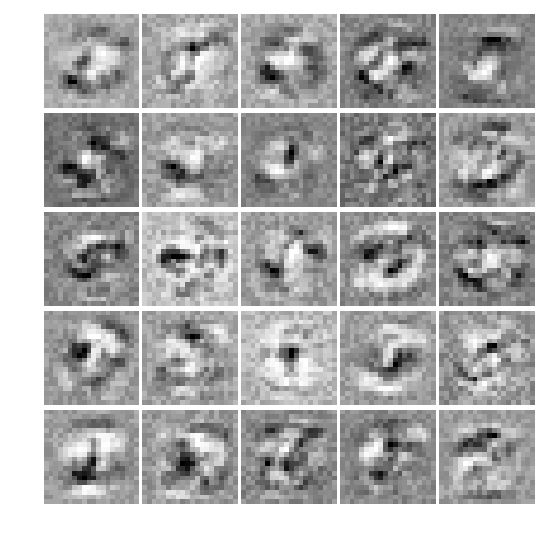

In [117]:
fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in xrange(dim):
    for j in xrange(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(theta_1_learned[k][1:].reshape(int(np.sqrt(N)), int(np.sqrt(N))).T,
                 cmap=plt.get_cmap('Greys'), 
                 interpolation = 'nearest')
        k += 1
        
plt.savefig('ex4_plots/fig_4_nn_learned.png', dpi=300)

Visualizing the neural net provided:

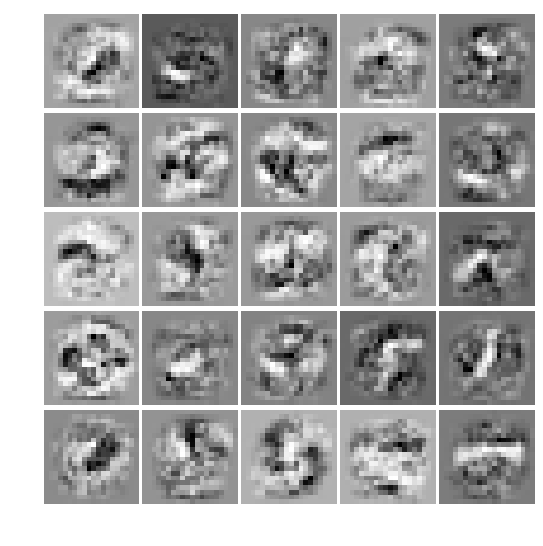

In [118]:
fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in xrange(dim):
    for j in xrange(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(theta_1[k][1:].reshape(int(np.sqrt(N)), int(np.sqrt(N))).T,
                 cmap=plt.get_cmap('Greys'),
                 interpolation = 'nearest')
        k += 1
        
plt.savefig('ex4_plots/fig_4_nn_saved.png', dpi=300)

## 3.1 Overfitting example

In [119]:
lam = 0.01

In [120]:
cost_history = []

res_overfit = minimize(nn_cost_function_grad_reg, nn_params_0, 
               method='L-BFGS-B', args=(X, Y, M, N, L, K, lam), jac=True, options={'maxiter': 100}) 

In [121]:
nn_params_learned_overfit = res_overfit['x']
np.savetxt('ex4_weights_learned/nn_params_learned_overfit.txt', nn_params_learned_overfit)

print 'Cost at best-fit theta: %.3f' % nn_cost_function_grad_reg(nn_params_learned_overfit, X, Y, M, N, L, K, lam)[0]

Cost at best-fit theta: 0.221


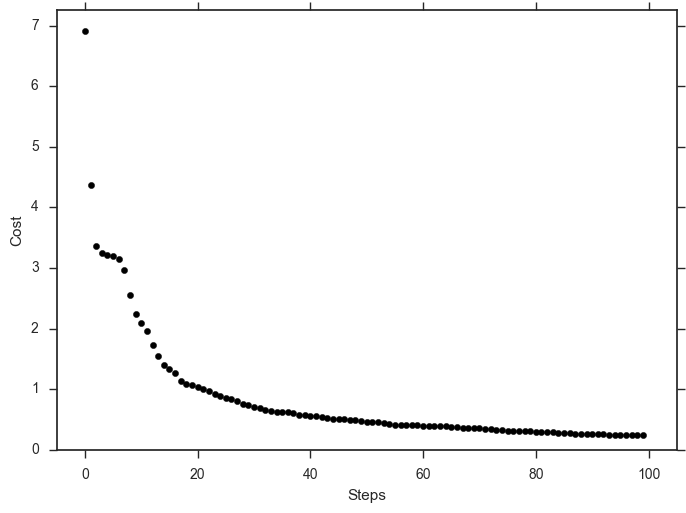

In [122]:
num_steps = 100

plt.figure()
plt.scatter(np.arange(num_steps), np.array(cost_history[:num_steps]), c='k', marker='o')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.xlim(-num_steps * 0.05, num_steps * 1.05)
plt.ylim(0, max(cost_history[:num_steps]) * 1.05)
plt.savefig('ex4_plots/cost_vs_steps_learned.png', dpi=300)

Alternatively, load the parameters learned from a previous training run.

In [96]:
# nn_params_learned_overfit = np.loadtxt('ex4_weights_learned/nn_params_learned_overfit.txt')

Accuracy of the overfitted neural net:

In [123]:
nn_accuracy(nn_params_learned_overfit, X, y)

0.97740000000000005

Accuracy of the neural net provided:

In [124]:
nn_accuracy(np.concatenate((theta_1.flatten(), theta_2.flatten())), X, y)

0.97519999999999996

Visualizing the overfit neural net:

In [125]:
theta_1_learned_overfit = nn_params_learned_overfit[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)

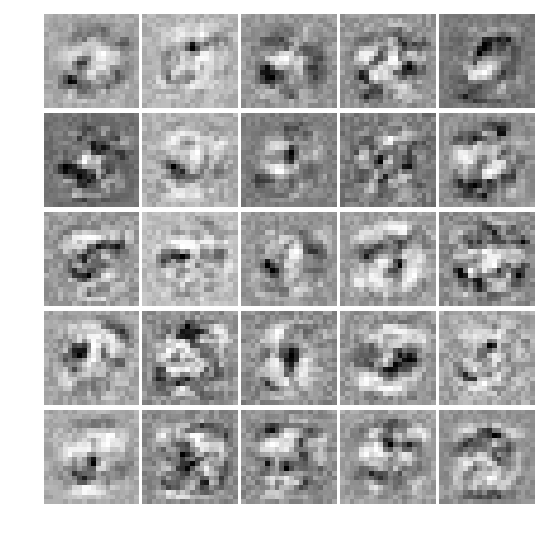

In [126]:
fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in xrange(dim):
    for j in xrange(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(theta_1_learned_overfit[k][1:].reshape(int(np.sqrt(N)), int(np.sqrt(N))).T,
                 cmap=plt.get_cmap('Greys'), 
                 interpolation = 'nearest')
        k += 1
        
plt.savefig('ex4_plots/fig_4_nn_learned_overfit.png', dpi=300)